# Plots for backtesting mutation growth rate paper

This notebook generates plots for the [paper/](paper/) directory. This assumes you've alread run
```sh
make update                       # Downloads and preprocesses data.
source run_backtesting.sh         # Runs backtesting experiments
```
Note that `make update` takes a couple hours the first time it is run (mostly in sequence alignment), and `mutrans.py` takes about 15 minutes on a GPU (will take much longer if no GPU is available).

In [1]:
import datetime
import math
import os
import pickle
import re
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pyro.distributions as dist
from pyrocov import mutrans, pangolin, stats
from pyrocov.stats import normal_log10bf
from pyrocov.util import pretty_print, pearson_correlation

In [2]:
# configure logging
logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

In [3]:
logging.getLogger().setLevel(logging.DEBUG)

In [4]:
# set matplotlib params
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams['figure.figsize'] = [8, 8]
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Avenir', 'DejaVu Sans']

## Load data

In [5]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("Loaded data from {} samples".format(len(columns["lineage"])))

Loaded data from 2161248 samples


In [6]:
type(columns)

dict

In [7]:
columns.keys()

dict_keys(['lineage', 'virus_name', 'accession_id', 'collection_date', 'location', 'add_location', 'day'])

In [8]:
for k in columns.keys():
    print(k, columns[k][0:2])

lineage ['B.1', 'B.1']
virus_name ['hCoV-19/Australia/NT12/2020', 'hCoV-19/Australia/NT13/2020']
accession_id ['EPI_ISL_426900', 'EPI_ISL_426901']
collection_date ['2020-03-25', '2020-03-25']
location ['Oceania / Australia / Northern Territory', 'Oceania / Australia / Northern Territory']
add_location ['', '']
day [115, 115]


Sanity checking case count time series:

In [9]:
if False:
    plt.figure(figsize=(8, 3))
    plt.plot(weekly_cases, lw=1, alpha=0.5)
    plt.yscale("symlog", linthresh=10)
    plt.ylim(0, None)
    plt.xlim(0, len(weekly_cases) - 1)
    plt.xlabel("week after 2019-12-01")
    plt.ylabel("confirmed cases");

    plt.figure(figsize=(8, 3))
    plt.plot(weekly_strains.sum(-1), lw=1, alpha=0.5)
    plt.yscale("symlog", linthresh=10)
    plt.ylim(0, None)
    plt.xlim(0, len(weekly_cases) - 1)
    plt.xlabel("week after 2019-12-01")
    plt.ylabel("sequenced samples");

In [10]:
# locations = set(location_id)
# N_usa = sum(1 for k in locations if "/ USA /" in k)
# N_uk = sum(1 for k in locations if "/ United Kingdom /" in k)
# N_other = len(locations) - N_usa - N_uk
# print(N_usa, N_uk, N_other)

We'll account for epidemiological dynamics in the form of random drift on top of our logistic growth model. Since random drift is inversely proportional to the local number of infections, we'll need a new data source for the number of infections in each region. We'll use JHU's confirmed case counts time series as a proxy for the number of total infections in each region.

## Load trained models

In [11]:
fits = torch.load("results/mutrans.pt", map_location="cpu")
first_key = list(fits.keys())[0]
for key in fits:
    print(key)
fits[first_key].keys()

('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 150, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 175, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 200, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 225, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 250, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 275, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 300, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 325, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 350, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 375, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 400, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 425, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 450, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 475, ())
('coef

dict_keys(['median', 'mean', 'std', 'losses', 'series', 'params', 'walltime', 'args', 'mutations', 'weekly_strains', 'weekly_cases', 'weekly_strains_shape', 'location_id', 'lineage_id_inv'])

In [12]:
for fit in fits.values():
    print(fit["weekly_strains_shape"])

(11, 592, 1281)
(13, 623, 1281)
(15, 658, 1281)
(17, 685, 1281)
(18, 718, 1281)
(20, 737, 1281)
(22, 758, 1281)
(24, 778, 1281)
(26, 802, 1281)
(27, 821, 1281)
(29, 869, 1281)
(31, 937, 1281)
(33, 993, 1281)
(34, 1034, 1281)
(36, 1057, 1281)
(38, 1065, 1281)
(40, 1069, 1281)


In [13]:
# This is really just the second fit
best_fit = list(fits.values())[1]
#pretty_print(best_fit, max_items=40)

Scale `coef` by 1/100 in all results.

In [14]:
ALREADY_SCALED = set()

def scale_tensors(x, names={"coef"}, scale=0.01, prefix=""):
    if id(x) in ALREADY_SCALED:
        return
    if isinstance(x, dict):
        for k, v in list(x.items()):
            if k in names:
                print(f"{prefix}.{k}")
                x[k] = v * scale
            elif k == "diagnostics":
                continue
            else:
                scale_tensors(v, names, scale, f"{prefix}.{k}")
    ALREADY_SCALED.add(id(x))
                
scale_tensors(fits)

.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 150, ()).median.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 150, ()).mean.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 150, ()).std.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 175, ()).median.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 175, ()).mean.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 175, ()).std.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 200, ()).median.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 200, ()).mean.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 200, ()).std.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 225, ()).median.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 225, ()).mean.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 225, ()).std.coef
.('coef_scal

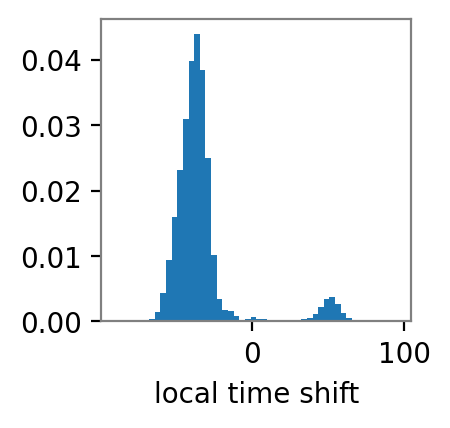

In [16]:
plt.figure(figsize=(2,2))
plt.hist(best_fit["params"]["local_time"].reshape(-1).numpy(), bins=50, density=True)
plt.xlabel("local time shift");

## Forecasting

In [18]:
import importlib
from pyrocov import mutrans_helpers

In [20]:
# Reload the import library helpers
importlib.reload(mutrans_helpers)

NameError: name 'mutrans_helpers' is not defined

In [19]:
importlib.reload(mutrans_helpers)
# Plot the forecasts of a specific model
k = list(fits.keys())
max_days = k[3]
fit = fits[k[3]]

In [20]:
logging.getLogger().setLevel(logging.ERROR)

DEBUG plot_fit_forecasts num_strains is 100
DEBUG num_strains is 100


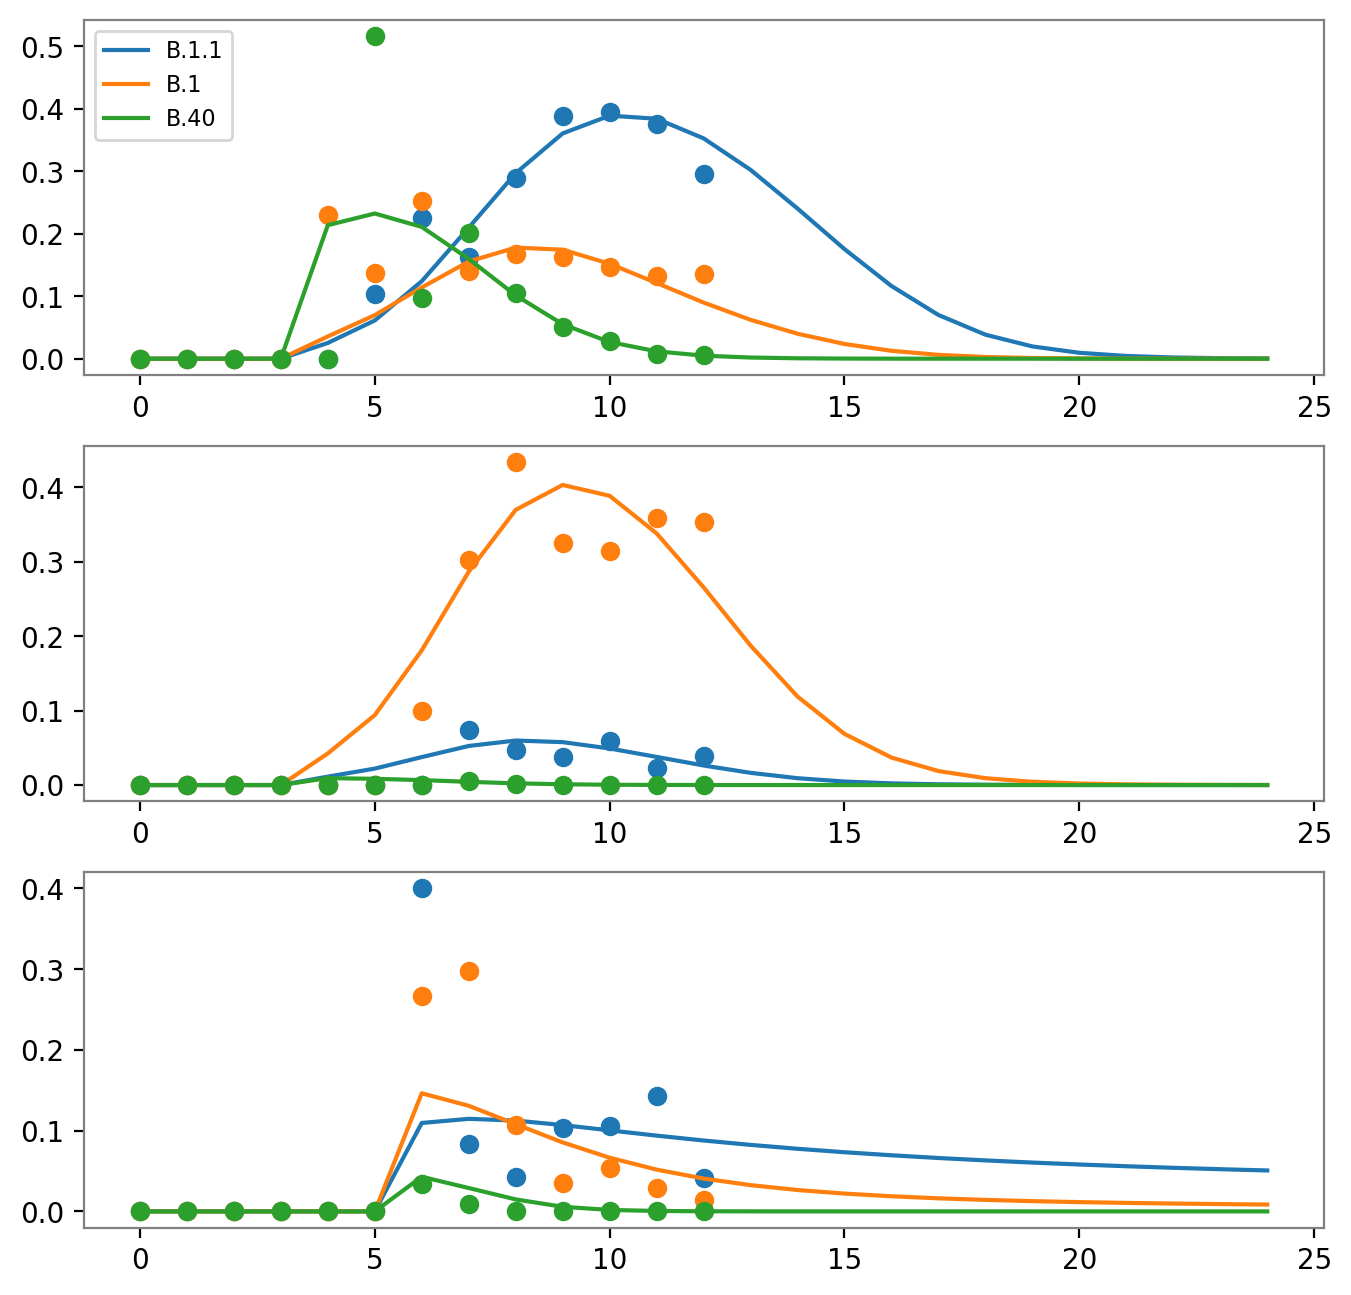

In [22]:
mutrans_helpers.plot_fit_forecasts(fits, 1)

DEBUG plot_fit_forecasts num_strains is 100
DEBUG num_strains is 100


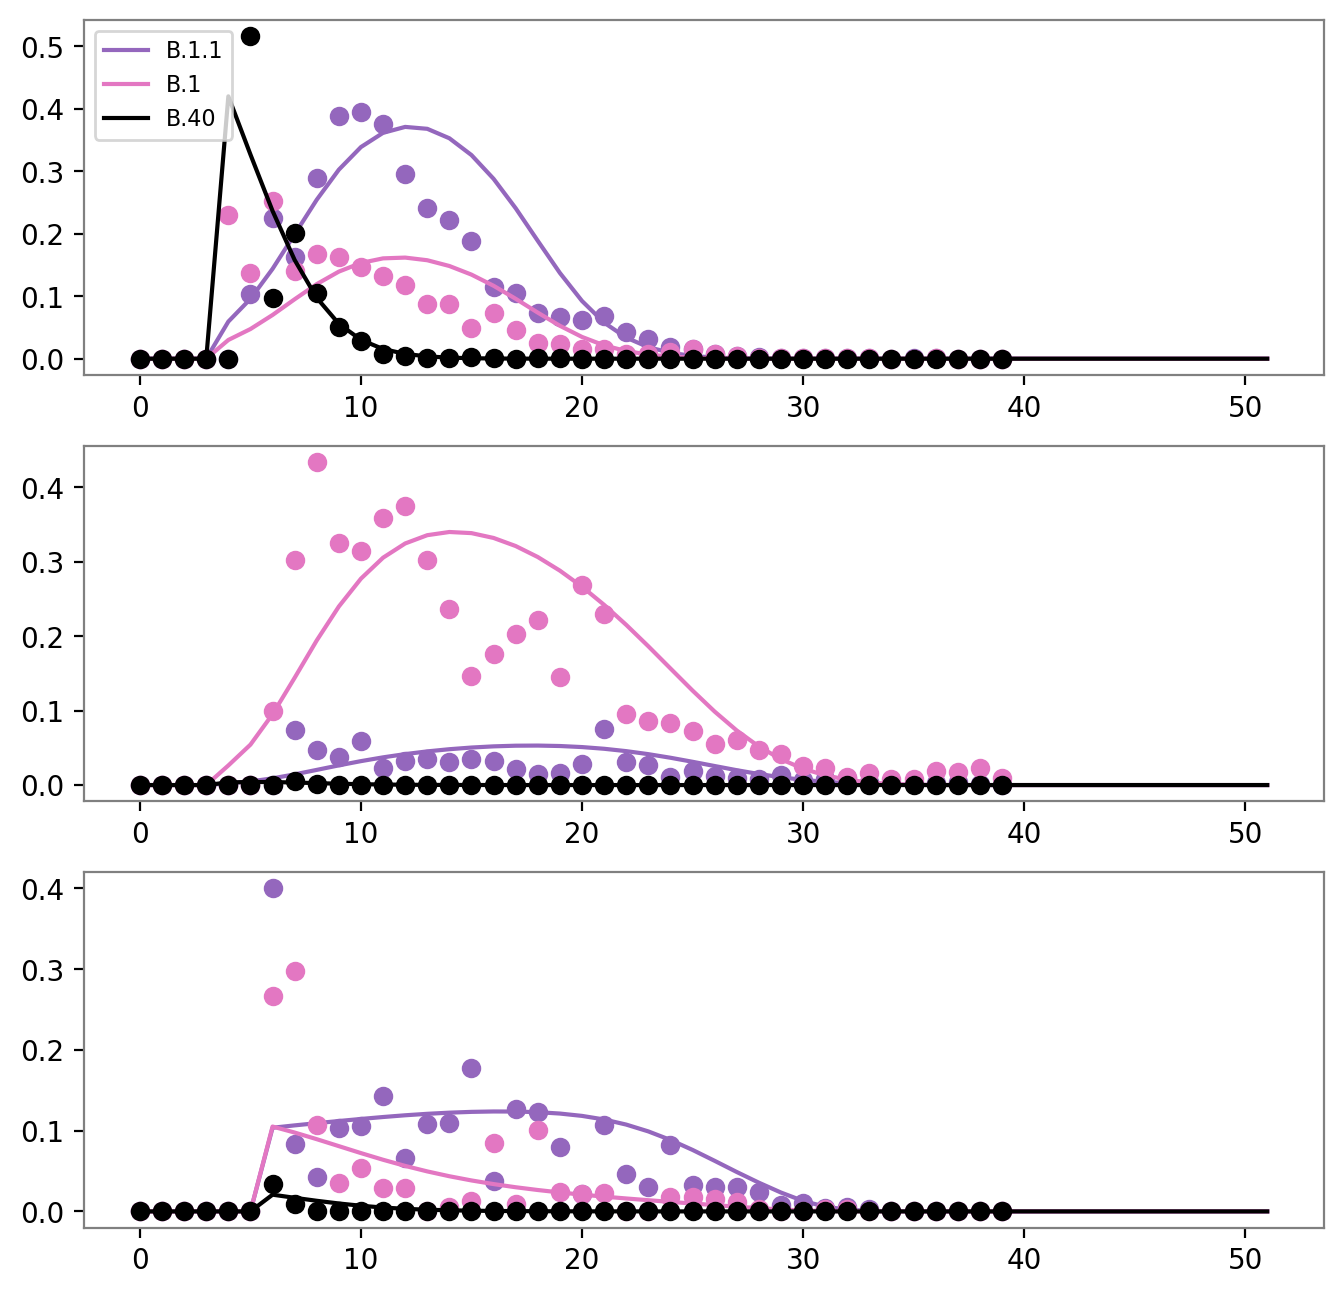

In [24]:
sids = mutrans_helpers.plot_fit_forecasts(fits, 16)

In [ ]:
avail_strains = get_available_strains(fits, 16)

In [ ]:
avail_strains[0:5]

In [ ]:
plot_fit_forecasts(fits, 16,strains_to_show=avail_strains[0:5])

In [ ]:
plot_fit_forecasts(fits, 16,strains_to_show=avail_strains[5:10])

In [ ]:
plot_fit_forecasts(fits, 16,strains_to_show=avail_strains[10:15])

In [ ]:
plot_fit_forecasts(fits, 16,strains_to_show=['B.1.177.4'])

In [ ]:
plot_fit_forecasts(fits, 16,strains_to_show=['B.1.2'])

In [ ]:
plot_fit_forecasts(fits, 16,strains_to_show=['B.1.427'])

In [ ]:
plot_fit_forecasts(fits, 16,strains_to_show=['B.1'])

In [ ]:
plot_fit_forecasts(fits, 16,strains_to_show=['P.1'])

In [ ]:
plot_fit_forecasts(fits, 16,strains_to_show=['B.1.1'])

In [ ]:
plot_fit_forecasts(fits, 16,strains_to_show=['B.1.429'])

In [ ]:
plot_fit_forecasts(fits, 16,strains_to_show=['B.1.617.2'])

In [ ]:
plot_fit_forecasts(fits, 16,strains_to_show=['B.1.177'])

In [ ]:
plot_fit_forecasts(fits, 16,strains_to_show=['B.1.1.7'])

In [ ]:
plot_fit_forecasts(fits, 16,strains_to_show=['B.1'])

In [ ]:
plot_fit_forecasts(fits, 16,strains_to_show=['B.1.1'])